In [1]:
import json
import matplotlib.pyplot as plt
import baltic as bt
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from copy import deepcopy

In [2]:
tree_file = '../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json'
out_path = './png/'

In [52]:
antigenic_tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'cTiter'})
genetic_tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'xvalue'})


Tree height: 2.472229
Tree length: 6.161171
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [55]:
def antigenically_uniform(node, tree):
        
    node_cTiters = [round(k.traits['cTiter'], 2) for k in tree.traverse_tree(node, include_all=True) if k.traits.has_key('cTiter')]
    node_uniform = len(set(node_cTiters)) == 1
    return node_uniform
                          
def collapse_antigenic_phenotypes(tree):
    tree_copy = deepcopy(tree)
    sorted_branches = sorted(tree_copy.nodes, key = lambda k: k.height, reverse=True)
    
    to_collapse = [ k for k in sorted_branches if antigenically_uniform(k, tree_copy) 
                   and not antigenically_uniform(k.parent, tree_copy)]
    
    for k in to_collapse:
        tree_copy.collapseSubtree(k, k.traits['clade'])

    return tree_copy 

collapsed_antigenic_tree = collapse_antigenic_phenotypes(antigenic_tree)
collapsed_antigenic_tree.drawTree()

In [32]:
def plot_tree(mtt):
    
    max_cTiter = max([k.traits['cTiter'] for k in mtt.Objects])
    branchWidth=2
    fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

    for k in mtt.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        yp=k.parent.y
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        cmap=plt.get_cmap('plasma') ## pick colour map based on trait
        c=cmap(k.traits['cTiter']/max_cTiter) ## colour with colour map based on height of branch
        
#         if k == mtt.root.children[0]:
#             continue
        
        if k.branchType=='leaf': ## if leaf...
            #s=30 ## tip size can be fixed
            
            if isinstance(k, bt.clade):
                s = 10+k.width
            else:
                s=10

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        ax.plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tight_layout()
    plt.show()


In [63]:
# collapsed_antigenic_tree.drawUnrooted()
# rando = [k for k in collapsed_antigenic_tree.Objects if k==collapsed_antigenic_tree.root.children[0]][0]
# for idx, k in enumerate(collapsed_antigenic_tree.Objects):
#     if k == rando:
#         del collapsed_antigenic_tree.Objects[idx]
#         break
        
collapsed_antigenic_tree.drawUnrooted()

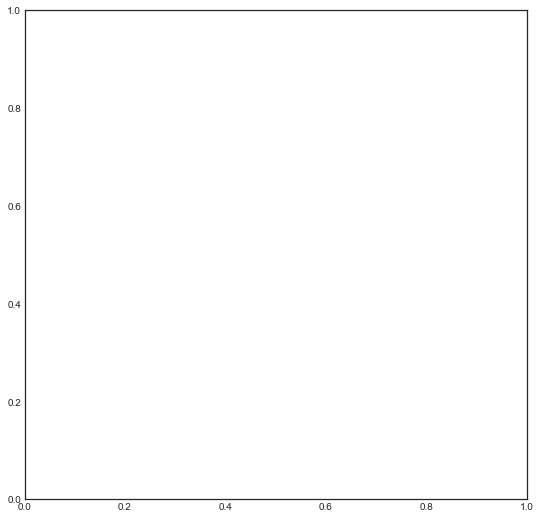

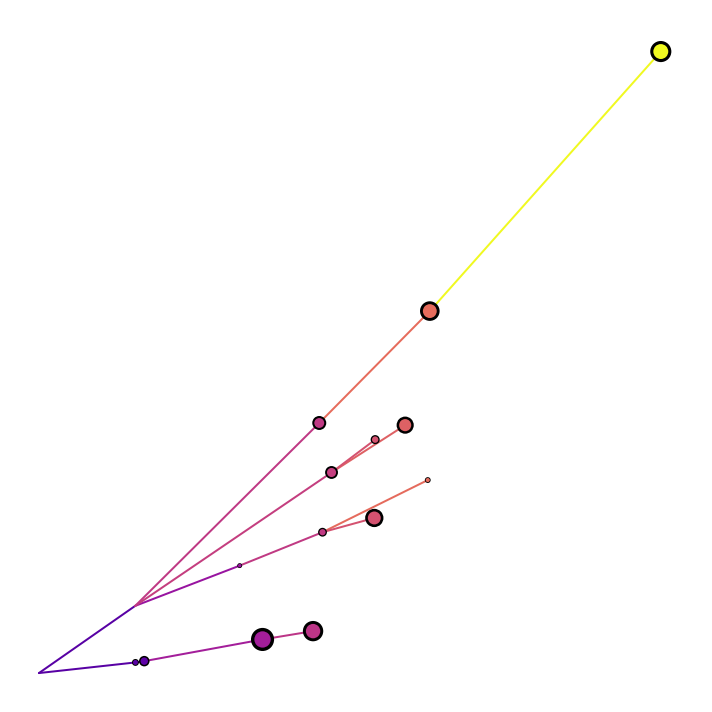

In [64]:
# fig, ax = plt.subplots(1,2,figsize=(12,12))
fig, ax = plt.subplots(figsize=(9,9))
# plt.sca(ax[0])
plot_tree(collapsed_antigenic_tree)
# plt.sca(ax[1])
# plot_tree(genetic_tree, colorby='cTiter', vmax=max_cTiter, color_callable=plt.get_cmap('viridis'))